In [42]:
import numpy as np
import rqcopt as oc
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# setup for problem
# get the setup for the problem
from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, super2choi
from opentn.optimization import compose_superops_list, frobenius_norm
d, N, gamma = 2, 4, 1
tau = 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma)
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

# 2 site superoperator ansatz
from opentn.transformations import lindbladian2super, create_supertensored_from_local
superop_nn = lindbladian2super(Li=[Lnn])
exp_nn_odd = exp_operator_dt(superop_nn, tau=tau/2, backend='jax')
exp_nn_even = exp_operator_dt(superop_nn, tau=tau, backend='jax')

print(np.linalg.matrix_rank(super2choi(exp_Lvec)))
print(frobenius_norm(compose_superops_list([exp_Lvec_odd, exp_Lvec_even, exp_Lvec_odd]), exp_Lvec))

55
0.0959176702323516


In [75]:
# how would we vectorize the identity?
from opentn.transformations import vectorize_dissipative, vectorize_hamiltonian, dissipative2liouvillian_full
Inn = np.eye(d**2)
print(np.allclose(vectorize_dissipative(Inn), np.zeros((d**4,d**4))), np.allclose(vectorize_hamiltonian(Inn), np.zeros((d**4,d**4))))
# as wrote out on paper, the identity "vectorized" is just zero
print(dissipative2liouvillian_full(L=Lnn, i=1, N=N, num_sites=2).shape)

True True
(256, 256)


In [76]:
from opentn.transformations import convert_supertensored2liouvillianfull
# corresponds to site order: (N-1, 0), (1, 2)
even_full_test = create_supertensored_from_local(exp_nn_even, N=N, pbc=False, layer=1)
swaped_test = convert_supertensored2liouvillianfull(even_full_test, N, d, shift_pbc=True)
np.allclose(swaped_test, exp_Lvec_even)

True

In [77]:
# now another question I have is even the components I am using would make isometries. CHECK
from opentn.transformations import factorize_psd_truncated, choi2ortho
from opentn.stiefel import is_isometry_2
print(is_isometry_2(choi2ortho(factorize_psd_truncated(super2choi(exp_nn_even.real), chi_max=2))))
print(is_isometry_2(choi2ortho(factorize_psd_truncated(super2choi(I_rest), chi_max=d**4))))

True
True


In [78]:
test_odd = create_supertensored_from_local(exp_nn_odd, N)
test_odd = convert_supertensored2liouvillianfull(test_odd, N, d)
print(np.allclose(test_odd@swaped_test@test_odd, exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd)) # AMAZING
print(frobenius_norm(test_odd@swaped_test@test_odd, exp_Lvec))

True
0.09591767023235137


# Next steps:
(18 OCT 2023)

1. I want the above functions to be a comprehensible framework. What does this mean?
    a. Their should be one "factory" that takes superop_local -> super_full_liouvillian that takes as argument the parity and shifts (PBC) for the even layer.
    b. I need to try this out fully when also changing the exp(L_full) to include the PBC for the term [N-1,0].
    c. Include a special case for the non PBC such that this old comparison still works
    c. Add even layer to unit tests 
2. Try optimization with the PBC case for St(N)
3. EXTRA: finish creation of identity maps!

In [79]:
# I need to change now create_2local_liouvillians to include pbc condition
from opentn.transformations import permute_cyclic
permute_cyclic(list(range(6)), direction='right')
# NOTE: a unittest I can write is constructing the same operator once with left and once with right!

[5, 0, 1, 2, 3, 4]

In [80]:
# trying out again things but with pbc=True!
from opentn.transformations import create_trotter_layers

d, N, gamma = 2, 4, 1
tau = 4

Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma, pbc=True)
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = create_trotter_layers(liouvillians=[Lvec, Lvec_odd, Lvec_even], tau=tau)

print(frobenius_norm(compose_superops_list([exp_Lvec_odd, exp_Lvec_even, exp_Lvec_odd]), exp_Lvec))

superop_nn = lindbladian2super(Li=[Lnn])

exp_nn_odd = exp_operator_dt(superop_nn, tau=tau/2, backend='jax')
exp_nn_even = exp_operator_dt(superop_nn, tau=tau, backend='jax')

test_even_pbc = create_supertensored_from_local(exp_nn_even, N, pbc=True, layer=1)
test_even_pbc = convert_supertensored2liouvillianfull(test_even_pbc, N, d, shift_pbc=True)

test_odd = create_supertensored_from_local(exp_nn_odd, N)
test_odd = convert_supertensored2liouvillianfull(test_odd, N, d)

0.14312675894435653


In [81]:
# these are supposed to fail 
print(np.allclose(create_supertensored_from_local(exp_nn_even, N, layer=1), create_supertensored_from_local(exp_nn_even, N, pbc=True, layer=1)))

False


In [82]:
print(np.allclose(test_odd@test_even_pbc@test_odd, exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd)) # AMAZING
print(np.allclose(Lvec, Lvec_odd+Lvec_even))

True
True


In [83]:
np.linalg.matrix_rank(super2choi(exp_Lvec)), 4**3, 2**4 # NOTE: the 2 comes from the fact that 2 kraus operators come out from the liouvillian acting on 2 sites.

(45, 64, 16)

In [84]:
# I want to create a utility function that converts the superoperator to orthogonal directly
from opentn.transformations import super2ortho
from opentn.stiefel import check_isometries
from opentn.optimization import model_stiefel_local
xs_pbc_stiefel = [super2ortho(x.real) for x in [exp_nn_odd, exp_nn_even, exp_nn_odd]]
print(check_isometries(xs_pbc_stiefel), [op.shape for op in xs_pbc_stiefel])
print(frobenius_norm(model_stiefel_local(xs_pbc_stiefel, N=N, d=d), exp_Lvec))

[True, True, True] [(8, 4), (8, 4), (8, 4)]
0.14312675894435722


In [15]:
# now it is time to define the elements for the optimization!
from opentn.stiefel import retract_stiefel, gradient_stiefel_vec, riemannian_hessian_vec
f_stiefel = lambda xi: frobenius_norm(model_stiefel_local(xi, N=N, d=d), exp_Lvec)
grad_stiefel = lambda xi: gradient_stiefel_vec(xi, f_stiefel)
hessian_stiefel = lambda xi: riemannian_hessian_vec(xi, f_stiefel)

In [19]:
from opentn.trust_region_rcopt import riemannian_trust_region_optimize
xs_pbc_1, f_pbc_1, err_pbc_1, radius_pbc_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_pbc_stiefel, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
radius 0.0025
iteration: 4
column : 0
column : 1
column : 2
radius 0.000625
iteration: 5
column : 0
column : 1
column : 2
radius 0.000625
iteration: 6
column : 0
column : 1
column : 2
radius 0.00125
iteration: 7
column : 0
column : 1
column : 2
radius 0.0025
iteration: 8
column : 0
column : 1
column : 2
radius 0.005
iteration: 9
column : 0
column : 1
column : 2
radius 0.00125
iteration: 10
column : 0
column : 1
column : 2
radius 0.00125
iteration: 11
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 12
column : 0
column : 1
column : 2
radius 0.000625
iteration: 13
column : 0
column : 1
column : 2
radius 0.000625
iteration: 14
column : 0
column : 1
column : 2
radius 0.000625
iteration: 15
column : 0
column : 1
column : 2
radius 0.000625
iteration: 16
colum

In [20]:
xs_pbc_2, f_pbc_2, err_pbc_2, radius_pbc_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_pbc_1, niter=20, radius_init=radius_pbc_1
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 1
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 2
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 3
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 4
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 5
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 6
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 7
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 8
column : 0
column : 1
column : 2
radius 0.000625
iteration: 9
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 10
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 11
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 12
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 13
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 14
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 15
column : 0
column :

In [25]:
check_isometries(xs_pbc_2)

[True, True, True]

0.8853557271233199


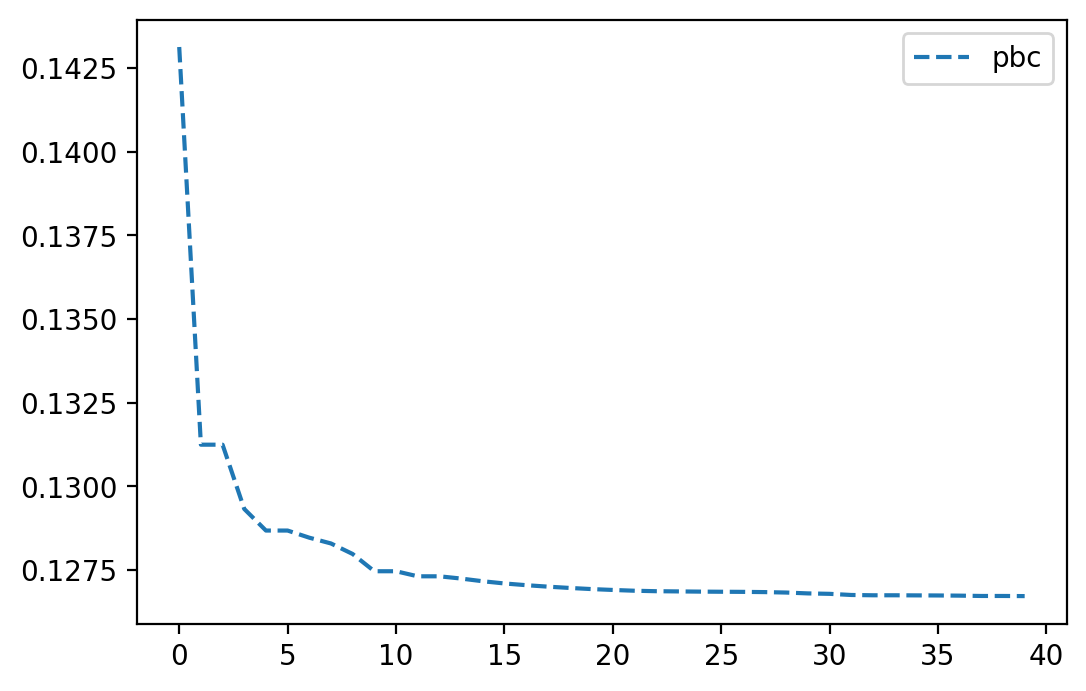

In [24]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.plot(f_pbc_1 + f_pbc_2, '--', label='pbc')
plt.legend()
print(f_pbc_2[-1]/f_pbc_1[0])

In [71]:
# just to be sure that everything is right: TODO: I need to check that the error of this model decreases with tau**3
taus = np.logspace(start=2, stop=-9, num=12, base=2)[::-1]
error_fro = []
for tau in taus:
    exp_tot_tau = exp_operator_dt(Lvec, tau=tau, backend='jax')
    exp_odd_tau = exp_operator_dt(Lvec_odd, tau=tau/2, backend='jax')
    exp_even_tau = exp_operator_dt(Lvec_even, tau=tau, backend='jax')
    error_fro.append(frobenius_norm(exp_odd_tau@exp_even_tau@exp_odd_tau,exp_tot_tau))

[1.953125e-03 3.906250e-03 7.812500e-03 1.562500e-02 3.125000e-02
 6.250000e-02 1.250000e-01 2.500000e-01 5.000000e-01 1.000000e+00
 2.000000e+00 4.000000e+00]


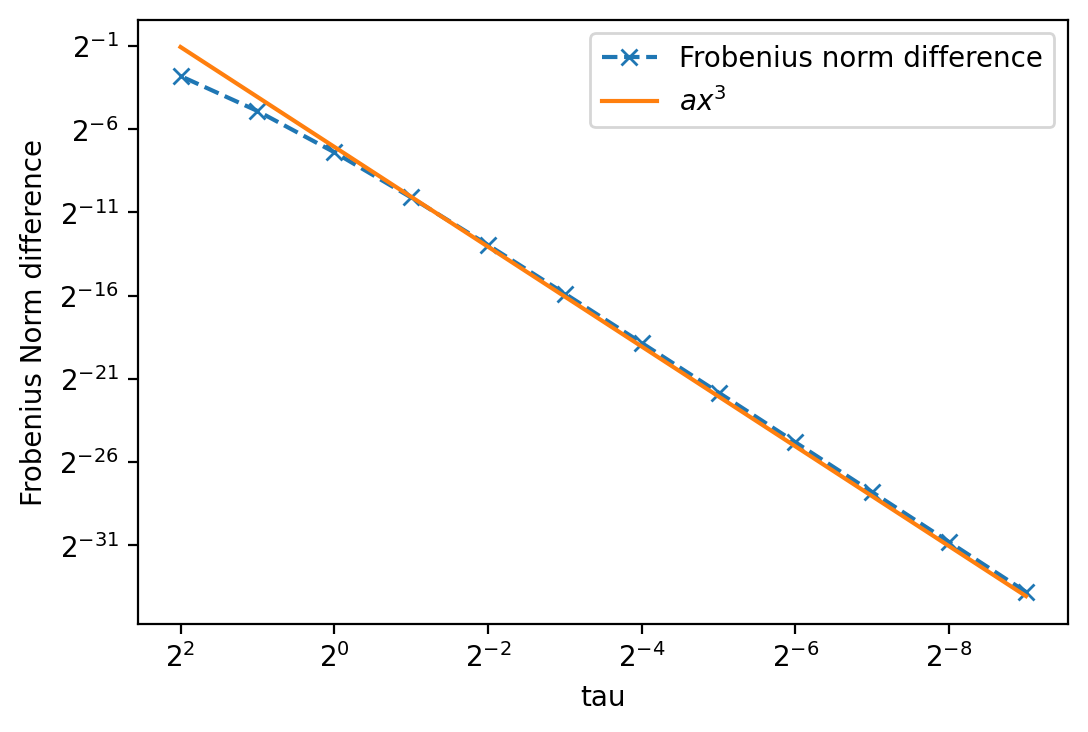

In [72]:
a = 0.0075
fig = plt.figure(dpi=200)
plt.loglog(taus, error_fro, '--x', base=2, label='Frobenius norm difference')
plt.plot(taus, a*taus**3, label=r'$a x^3$')
plt.gca().invert_xaxis()
plt.ylabel(r'Frobenius Norm difference')
plt.xlabel('tau')
plt.legend()
print(taus)

In [ ]:
# more checks? I don't know. 
# the check that Lvec = Leven + Lodd is already happening inside the creation.